In [13]:
import sys 
import os
sys.path.append(os.path.abspath('../models'))
sys.path.append(os.path.abspath('../dev'))

from mads_datasets import DatasetFactoryProvider, DatasetType
from mltrainer.preprocessors import BasePreprocessor
from mltrainer import Trainer, TrainerSettings, ReportTypes, metrics

from helpers import get_last_accuracy_from_tensorboard

import torch.optim as optim
import torch

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os

In [17]:
fashionfactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)
preprocessor = BasePreprocessor()

batchsize = 32

streamers = fashionfactory.create_datastreamer(batchsize=batchsize, preprocessor=preprocessor)
train = streamers["train"]
valid = streamers["valid"]

trainstreamer = train.stream()
validstreamer = valid.stream()

accuracy = metrics.Accuracy()
loss_func = torch.nn.CrossEntropyLoss()

2025-05-15 20:43:48.688 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/azureuser/.cache/mads_datasets/fashionmnist
2025-05-15 20:43:48.689 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/azureuser/.cache/mads_datasets/fashionmnist/fashionmnist.pt


In [6]:
from DNN import DenseNeuralNetwork

units = [1024, 512, 256, 128, 64, 32, 16]

epochs = 20
accuracies5 = []
dir = "modellogs/UNITS/EPOCH20/"

for units1 in units:
    row = []
    for units2 in units:
        logdir = f"{dir}u{units1}_u{units2}_e{epochs}"

        settings = TrainerSettings(
            epochs=epochs,
            metrics=[accuracy],
            logdir="modellogs",
            train_steps=100,
            valid_steps=100,
            reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML]
        )

        model = DenseNeuralNetwork(num_classes=10, units1=units1, units2=units2)
        settings.logdir = f"{dir}u{units1}_u{units2}_e{epochs}"

        trainer = Trainer(
            model=model,
            settings=settings,
            loss_fn=loss_func,
            optimizer=optim.Adam,
            traindataloader=trainstreamer,
            validdataloader=validstreamer,
            scheduler=optim.lr_scheduler.ReduceLROnPlateau
        )

        trainer.loop()
        
        tb_subdirs = [os.path.join(logdir, d) for d in os.listdir(logdir) if os.path.isdir(os.path.join(logdir, d))]

        # Zoek eerste subdir met tensorboard events
        tb_dir = next((d for d in tb_subdirs if any("events.out.tfevents" in f for f in os.listdir(d))), None)

        if tb_dir:
            last_acc = get_last_accuracy_from_tensorboard(tb_dir)
        else:
            last_acc = np.nan
        
        row.append(last_acc)
    accuracies5.append(row)

2025-05-15 20:16:58.297 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/UNITS/EPOCH20/u1024_u1024_e20/20250515-201658
2025-05-15 20:16:59.549 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 100/100 [00:01<00:00, 81.83it/s]
2025-05-15 20:17:01.040 | INFO     | mltrainer.trainer:report:205 - Epoch 0 train 0.8352 test 0.6589 metric ['0.7475']
100%|██████████| 100/100 [00:01<00:00, 73.84it/s]
2025-05-15 20:17:02.656 | INFO     | mltrainer.trainer:report:205 - Epoch 2 train 0.6102 test 0.5670 metric ['0.8006']
100%|██████████| 100/100 [00:01<00:00, 73.62it/s]
2025-05-15 20:17:04.279 | INFO     | mltrainer.trainer:report:205 - Epoch 4 train 0.5480 test 0.6065 metric ['0.7562']
2025-05-15 20:17:04.280 | INFO     | mltrainer.trainer:__call__:248 - best loss: 0.5670, current loss 0.6065.Counter 1/10.
100%|██████████| 100/100 [00:01<00:00, 80.94it/s]
2025-05-15 20:17:05.774 | I

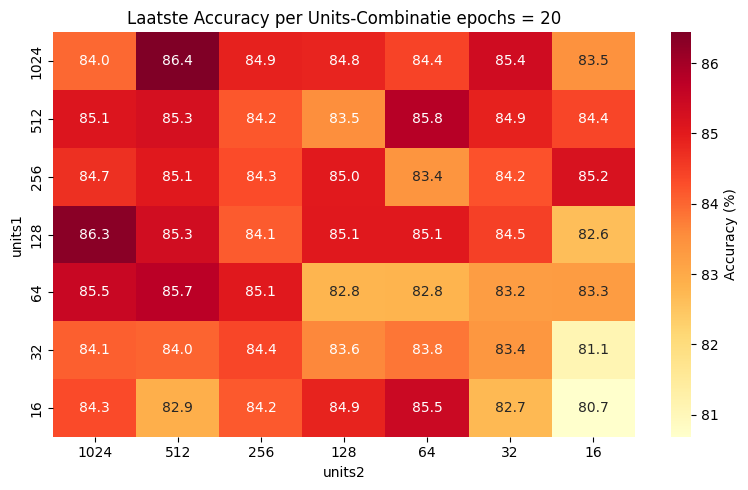

In [7]:
# Plot de heatmap
plt.figure(figsize=(8, 5))
ax = sns.heatmap(
    accuracies5,
    annot=True,
    fmt=".1f",
    xticklabels=units,
    yticklabels=units,
    cmap="YlOrRd",
    cbar_kws={'label': 'Accuracy (%)'}
)
ax.set_xlabel("units2")
ax.set_ylabel("units1")
ax.set_title("Laatste Accuracy per Units-Combinatie epochs = 20")
plt.tight_layout()
plt.savefig("heatmap_epochs5")
plt.show()

In [18]:
units = [1024, 512]
epochs = 20
results = []

settings = TrainerSettings(
    epochs=epochs,
    metrics=[accuracy],
    logdir="modellogs",
    train_steps=100,
    valid_steps=100,
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML]
)

model = DenseNeuralNetwork (num_classes=10, units1=1024, units2=512)
settings.logdir = f"modellogs/SGD/u{units1}_u{units2}_e{epochs}"

trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_func,
    optimizer=optim.SGD,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=optim.lr_scheduler.ReduceLROnPlateau
)

trainer.loop()


2025-05-15 20:43:58.602 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/SGD/u512_u512_e20/20250515-204358
2025-05-15 20:43:58.603 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 200.33it/s]
2025-05-15 20:43:59.361 | INFO     | mltrainer.trainer:report:205 - Epoch 0 train 2.3006 test 2.2919 metric ['0.1672']
100%|██████████| 100/100 [00:00<00:00, 188.13it/s]
2025-05-15 20:44:00.150 | INFO     | mltrainer.trainer:report:205 - Epoch 2 train 2.2810 test 2.2715 metric ['0.2569']
100%|██████████| 100/100 [00:00<00:00, 188.46it/s]
2025-05-15 20:44:00.933 | INFO     | mltrainer.trainer:report:205 - Epoch 4 train 2.2623 test 2.2538 metric ['0.3128']
100%|██████████| 100/100 [00:00<00:00, 206.78it/s]
2025-05-15 20:44:01.671 | INFO     | mltrainer.trainer:report:205 - Epoch 6 train 2.2432 test 2.2349 metric ['0.3497']
100%|██████████| 100/100 [00:00<00:00, 205.91it/s]
2025-05-15 20:44:02.409 | INFO     | mltrainer.trainer:report:205 - Epoch 8 train 2.2244 test 2.2145 metric ['0.3966']
100%|██████████| 100/100 [00:00<00:00, 210.23it/s]
2025-05-15 20:44:03.137 | INFO     | mltrainer.trainer:report:205 - Epoch 10 train 2.2087 test 2.20

In [19]:
from DNN import DeepNeuralNetwork

units1 = 1024
units2 = 512
units3 = 256
epochs = 20

settings = TrainerSettings(
            epochs=epochs,
            metrics=[accuracy],
            logdir="modellogs",
            train_steps=100,
            valid_steps=100,
            reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML]
        )

model = DeepNeuralNetwork (num_classes=10, units1=units1, units2=units2, units3 = units3)
settings.logdir = f"modellogs/DEEP/u{units1}_u{units2}_u{units3}_e{epochs}"
        
trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_func,
    optimizer=optim.Adam,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=optim.lr_scheduler.ReduceLROnPlateau
)

trainer.loop()


2025-05-15 20:46:35.743 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/DEEP/u1024_u512_u256_e20/20250515-204635
2025-05-15 20:46:35.745 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 102.08it/s]
2025-05-15 20:46:37.024 | INFO     | mltrainer.trainer:report:205 - Epoch 0 train 0.9923 test 0.7275 metric ['0.7228']
100%|██████████| 100/100 [00:00<00:00, 105.63it/s]
2025-05-15 20:46:38.247 | INFO     | mltrainer.trainer:report:205 - Epoch 2 train 0.6434 test 0.5889 metric ['0.7822']
100%|██████████| 100/100 [00:00<00:00, 106.25it/s]
2025-05-15 20:46:39.465 | INFO     | mltrainer.trainer:report:205 - Epoch 4 train 0.6056 test 0.5717 metric ['0.7931']
100%|██████████| 100/100 [00:01<00:00, 94.71it/s]
2025-05-15 20:46:40.808 | INFO     | mltrainer.trainer:report:205 - Epoch 6 train 0.5195 test 0.5612 metric ['0.7963']
100%|██████████| 100/100 [00:01<00:00, 96.51it/s]
2025-05-15 20:46:42.138 | INFO     | mltrainer.trainer:report:205 - Epoch 8 train 0.5207 test 0.5160 metric ['0.8069']
100%|██████████| 100/100 [00:00<00:00, 103.00it/s]
2025-05-15 20:46:43.383 | INFO     | mltrainer.trainer:report:205 - Epoch 10 train 0.5102 test 0.6321